In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!pip install torchmetrics
!pip install segmentation_models_pytorch
!pip install albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=63a06ae40b56d6b4f93aee03c0d6c39787a3262fac3c78e44abe680d333d95da
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=e7607cee5367ef3f60bddc7607dd01cf256b8fc797b2d53881c2a2cd044f5b22
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-p

In [ ]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from torchmetrics import Dice, JaccardIndex
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2 # np.array -> torch.tensor
import os
from tqdm import tqdm
from glob import glob
from torchvision.datasets import VOCSegmentation


In [ ]:
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]

VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask): # mask là 1 image RGB (H, W, 3)
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32) # tạo 1 object mask (H, W, 21)
        for label_index, label in enumerate(VOC_COLORMAP):
          segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float) # mask == label trả về matrix T/F (H, W, 3) check từng pixel theo chiều sâu channels.
                                                                                              # np.all sẽ kiểm tra nếu pixel nào có channel cùng màu với VOC_COLORMAP thì trả về True, ta dc 1 matrix True/False (H, W).
                                                                                              # astype() convert matrix [True False] về kiểu float [1. 0.]

        return segmentation_mask #0, 1, 2, 3, ..., 20 (H, W, C)

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
          transformed = self.transform(image=image, mask=mask)
          image = transformed["image"]
          mask = transformed["mask"]
        return image, mask.argmax(dim=2).squeeze() #torch.tensor argmax()-> (H, W, 1) -> (H, W) #numpy

In [ ]:
trainsize = 256

train_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Blur(),
    A.Sharpen(),
    A.RGBShift(),
    A.Cutout(num_holes=5, max_h_size=25, max_w_size=25, fill_value=0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

test_trainsform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(), # numpy.array -> torch.tensor (B, 3, H, W)
])

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Using downloaded and verified file: /root/data/pascal_voc/VOCtrainval_11-May-2012.tar
Extracting /root/data/pascal_voc/VOCtrainval_11-May-2012.tar to /root/data/pascal_voc


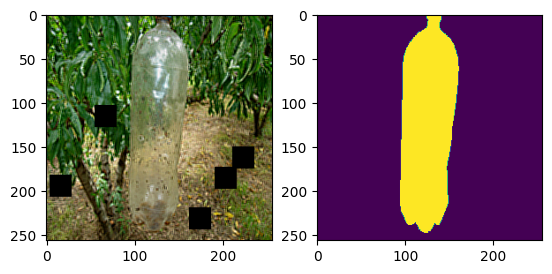

In [ ]:
train_dataset = PascalVOCSearchDataset(image_set="train", download=False, transform=train_transform)
test_dataset = PascalVOCSearchDataset(image_set="val", download=False, transform=test_trainsform)

id = random.randint(0, train_dataset.__len__())

image, mask = train_dataset.__getitem__(id)
plt.subplot(1, 2, 1)
plt.imshow(unorm(image).permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.show()


In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def intersectionAndUnionGPU(output, target, K, ignore_index=255):
    # 'K' classes, output and target sizes are N or N * L or N * H * W, each value in range 0 to K - 1.
    assert (output.dim() in [1, 2, 3])
    assert output.shape == target.shape
    output = output.view(-1)
    target = target.view(-1)
    output[target == ignore_index] = ignore_index
    intersection = output[output == target]
    area_intersection = torch.histc(intersection, bins=K, min=0, max=K-1)
    area_output = torch.histc(output, bins=K, min=0, max=K-1)
    area_target = torch.histc(target, bins=K, min=0, max=K-1)
    area_union = area_output + area_target - area_intersection
    return area_intersection, area_union, area_target

In [ ]:
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#load data
batch_size = 16
n_workers = os.cpu_count()
print("num_workers =", n_workers)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=n_workers)

#model
model = smp.create_model("PSPNet", "resnet101", "imagenet", 3, 21).to(device)

#loss
criterion = nn.CrossEntropyLoss() # CrossEntropy loss cho multiple classes

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_eps = 20

#metrics
dice_fn = torchmetrics.Dice(num_classes=21, average="macro").to(device)
iou_fn = torchmetrics.JaccardIndex(num_classes=21, task="multiclass", average="macro").to(device)

#meter
intersection_meter = AverageMeter()
train_loss_meter = AverageMeter()
union_meter = AverageMeter()
target_meter = AverageMeter()

num_workers = 2


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:04<00:00, 40.9MB/s]


In [ ]:
for ep in range(1, 1+n_eps):
  train_loss_meter.reset()
  intersection_meter.reset()
  union_meter.reset()
  target_meter.reset()
  model.train()

  for batch_id, (x, y) in enumerate(tqdm(trainloader), start=1):
    optimizer.zero_grad()
    n = x.shape[0]
    x = x.to(device).float()
    y = y.to(device).long() # hàm entropy loss nhận output là indices của class trong class_list nên chuyển sang long = int64
    y_hat = model(x) #(B, C, H, W)
    loss = criterion(y_hat, y) #(B, C, H, W) >< (B, H, W)
    loss.backward()
    optimizer.step()

    # save metrics
    with torch.no_grad():
      train_loss_meter.update(loss.item())
      y_hat_mask = y_hat.argmax(dim=1).squeeze(1) # (B, C, H, W) -> (B, 1, H, W) -> (B, H, W)
      intersection, union, target = intersectionAndUnionGPU(y_hat_mask.float(), y.float(), 21)

      train_loss_meter.update(loss.item(), n)
      intersection_meter.update(intersection)
      union_meter.update(union)
      target_meter.update(target)

  with torch.no_grad():
    iou_class = intersection_meter.sum / (union_meter.sum + 1e-10)  # vector 21D

    dice_class = (2 * intersection_meter.sum) / (intersection_meter.sum + union_meter.sum + 1e-10) #vector 21D

    mIoU = torch.mean(iou_class)  #mean vector 21D
    mDice = torch.mean(dice_class)  #mean vector 21D

  print("EP {}, train loss = {}, IoU = {}, dice = {}".format(
      ep, train_loss_meter.avg, mIoU, mDice
  ))
  if ep >= 15:
      torch.save(model.state_dict(), "/content/modelPSPNet_ep_{}.pth".format(ep))

 28%|██▊       | 26/92 [08:45<22:13, 20.21s/it]


KeyboardInterrupt: ignored

In [ ]:
# evaluation
model.eval()
test_intersection_meter = AverageMeter()
test_union_meter = AverageMeter()
test_target_meter = AverageMeter()
with torch.no_grad():
  for batch_id, (x, y) in enumerate(tqdm(testloader), start = 1):
    n = x.shape[0]
    x = x.to(device).float()
    y = y.to(device).long()
    y_hat = model(x)
    y_hat_mask = y_hat.argmax(dim = 1).squeeze()

    intersection, union, target = intersectionAndUnionGPU(y_hat_mask.float(), y.float(), 21)
    intersection_meter.update(intersection)
    union_meter.update(union)
    target_meter.update(target)

  iou_class = intersection_meter.sum / (union_meter.sum + 1e-10)  # vector 21D
  accuracy_class = test_intersection_meter.sum / (test_target_meter.sum + 1e-10)
  dice_class = (2 * intersection_meter.sum) / (intersection_meter.sum + union_meter.sum + 1e-10) #vector 21D
  mAcc = torch.mean(accuracy_class)
  mIoU = torch.mean(iou_class)  #mean vector 21D
  mDice = torch.mean(dice_class)  #mean vector 21D
print("TEST: acc = {}, iou = {}, dice = {}".format(mAcc, mIoU, mDice))



 11%|█         | 10/91 [01:38<13:18,  9.86s/it]


KeyboardInterrupt: ignored

In [ ]:
# predict
id = random.randint(0, train_dataset.__len__())

with torch.no_grad():
  model.eval()
  x, y = test_dataset.__getitem__(id)
  y_predict = model(x.unsqueeze(0).to(device)).argmax(dim=1).squeeze().cpu().numpy()
  print(np.unique(y_predict))
  print(y_predict.shape)
  color_mask_predict = np.zeros((*y_predict.shape, 3))
  for i, color in enumerate(VOC_COLORMAP):
    color_mask_predict[y_predict==i] = np.array(color)
  color_mask = np.zeros((*y_predict.shape, 3))
  for i, color in enumerate(VOC_COLORMAP):
    color_mask[y==i] = np.array(color)
  plt.subplot(1,3,1)
  plt.imshow(unorm(x).permute(1, 2, 0))
  plt.subplot(1,3,2)
  plt.imshow(color_mask)
  plt.subplot(1,3,3)
  plt.imshow(color_mask_predict)
  plt.show()